In [1]:
import time

import IPython
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from scnn.losses import mse_loss
from scnn.sh import spherical_harmonic
from scnn.sim import compartment_model_simulation
from scnn.models import MLPModel

sns.set_theme()

if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    raise Exception("CUDA not available")

BATCH_SIZE = int(5e2)
N_BATCHES = int(1e6)
SNR = 50

NVIDIA RTX A1000 6GB Laptop GPU


In [2]:
# Acquisition protocol

bvals = torch.round(
    torch.tensor(np.loadtxt("../data/mri/preprocessed/sub-01/dwi.bval") / 1e3),
    decimals=1,
).float()
bvecs = torch.tensor(np.loadtxt("../data/mri/preprocessed/sub-01/dwi.bvec").T).float()

idx = bvals > 0
bvals = bvals[idx]
bvecs = bvecs[idx]

bs = torch.unique(bvals)
n_shells = len(bs)
shell_indices = [torch.where(bvals == b)[0] for b in bs]

bvecs_isft_per_shell = []
bvecs_sft_per_shell = []
for idx in shell_indices:
    shell_bvecs = bvecs[idx]
    thetas = torch.arccos(shell_bvecs[:, 2])
    phis = (torch.arctan2(shell_bvecs[:, 1], shell_bvecs[:, 0]) + 2 * np.pi) % (
        2 * np.pi
    )
    bvecs_isft = torch.zeros(len(shell_bvecs), 45)
    for l in range(0, 8 + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = spherical_harmonic(
                l, m, thetas, phis
            )
    bvecs_isft_per_shell.append(bvecs_isft)
    bvecs_sft = torch.zeros((45, len(shell_bvecs)), dtype=float)
    bvecs_sft[0:45] = (
        torch.linalg.pinv(bvecs_isft[:, 0:45].T @ bvecs_isft[:, 0:45])
        @ bvecs_isft[:, 0:45].T
    )
    bvecs_sft_per_shell.append(bvecs_sft.float())

In [3]:
# Validation dataset

validation_signals = torch.load("../validation_signals.pt")
validation_targets = torch.load("../validation_targets.pt")

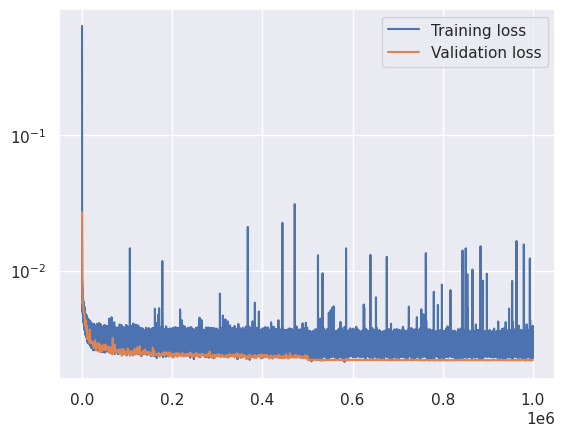

Training lasted 293 min


In [4]:
# Train without rotations

model = MLPModel(120, 47).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

training_odfs_sh = torch.load("../data/odfs/training_odfs_sh.pt")

training_losses = []
validation_losses = []

start_time = time.time()

for batch in range(1, N_BATCHES + 1):
    if batch == int(0.5 * N_BATCHES) or batch == int(0.75 * N_BATCHES):
        scheduler.step()

    torch.random.manual_seed(batch)
    batch_ds = torch.rand(BATCH_SIZE) * 3
    batch_fs = torch.rand(BATCH_SIZE)
    np.random.seed(batch)
    batch_odfs_sh = training_odfs_sh[
        np.random.choice(len(training_odfs_sh), BATCH_SIZE)
    ]
    batch_targets = torch.hstack(
        (batch_odfs_sh, batch_ds.unsqueeze(1), batch_fs.unsqueeze(1))
    )

    batch_ads = torch.vstack((batch_ds, batch_ds)).T
    batch_rds = torch.vstack(
        (
            torch.zeros(BATCH_SIZE),
            (1 - batch_fs) * batch_ds,
        )
    ).T
    batch_fs = torch.vstack((batch_fs, 1 - batch_fs)).T

    batch_signals = torch.zeros(BATCH_SIZE, 120)
    for j, b in enumerate(bs):
        shell_signals = (
            compartment_model_simulation(
                b,
                bvecs_isft_per_shell[j],
                batch_ads,
                batch_rds,
                batch_fs,
                batch_odfs_sh,
            )
            .cpu()
            .squeeze(-1)
        )
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        batch_signals[:, shell_indices[j]] = shell_signals.squeeze(-1).float()

    y = model(batch_signals.to(device))
    loss = mse_loss(y, batch_targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    training_losses.append(loss.item())
    print(f"batch {batch}, loss = {loss.item()}", end="\r")

    if batch == 1 or batch % 1000 == 0 or batch == N_BATCHES:
        model.eval()
        with torch.no_grad():
            validation_preds = torch.zeros(validation_targets.size()).to(device)
            for i in range(0, len(validation_signals), BATCH_SIZE):
                idx = torch.arange(i, i + BATCH_SIZE)
                validation_preds[idx] = model(validation_signals[idx].to(device))
            validation_losses.append(
                mse_loss(validation_preds, validation_targets).item()
            )
        model.train()

        if batch > 1:
            IPython.display.clear_output(wait=True)
            plt.plot(training_losses)
            plt.plot(
                torch.linspace(1, batch, len(validation_losses)), validation_losses
            )
            plt.legend(["Training loss", "Validation loss"])
            plt.yscale("log")
            plt.show()

print(f"Training lasted {int((time.time() - start_time) / 60)} min")
torch.save(model.state_dict(), "../mlp_weights.pt")

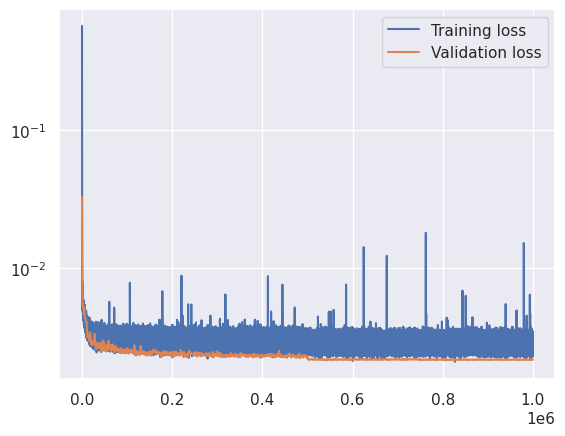

Training lasted 282 min


In [5]:
# Train with rotations

Rs = torch.tensor(
    np.concatenate(
        (
            np.eye(45)[np.newaxis],
            np.load("../Rs.npy").reshape(-1, 45, 45),
        ),
        axis=0,
    )
).float()

model = MLPModel(120, 47).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

training_odfs_sh = torch.load("../data/odfs/training_odfs_sh.pt")

training_losses = []
validation_losses = []

start_time = time.time()

for batch in range(1, N_BATCHES + 1):
    if batch == int(0.5 * N_BATCHES) or batch == int(0.75 * N_BATCHES):
        scheduler.step()

    torch.random.manual_seed(batch)
    batch_ds = torch.rand(BATCH_SIZE) * 3
    batch_fs = torch.rand(BATCH_SIZE)
    np.random.seed(batch)
    np.random.seed(batch)
    batch_odfs_sh = (
        Rs[np.random.choice(len(Rs), BATCH_SIZE)]
        @ training_odfs_sh[
            np.random.choice(len(training_odfs_sh), BATCH_SIZE)
        ].unsqueeze(-1)
    ).squeeze(-1)
    batch_targets = torch.hstack(
        (batch_odfs_sh, batch_ds.unsqueeze(1), batch_fs.unsqueeze(1))
    )

    batch_ads = torch.vstack((batch_ds, batch_ds)).T
    batch_rds = torch.vstack(
        (
            torch.zeros(BATCH_SIZE),
            (1 - batch_fs) * batch_ds,
        )
    ).T
    batch_fs = torch.vstack((batch_fs, 1 - batch_fs)).T

    batch_signals = torch.zeros(BATCH_SIZE, 120)
    for j, b in enumerate(bs):
        shell_signals = (
            compartment_model_simulation(
                b,
                bvecs_isft_per_shell[j],
                batch_ads,
                batch_rds,
                batch_fs,
                batch_odfs_sh,
            )
            .cpu()
            .squeeze(-1)
        )
        shell_signals = torch.abs(
            shell_signals
            + torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
            + 1j
            * torch.normal(
                mean=torch.zeros(shell_signals.size()),
                std=torch.ones(shell_signals.size()) / SNR,
            )
        )
        batch_signals[:, shell_indices[j]] = shell_signals.squeeze(-1).float()

    y = model(batch_signals.to(device))
    loss = mse_loss(y, batch_targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    training_losses.append(loss.item())
    print(f"batch {batch}, loss = {loss.item()}", end="\r")

    if batch == 1 or batch % 1000 == 0 or batch == N_BATCHES:
        model.eval()
        with torch.no_grad():
            validation_preds = torch.zeros(validation_targets.size()).to(device)
            for i in range(0, len(validation_signals), BATCH_SIZE):
                idx = torch.arange(i, i + BATCH_SIZE)
                validation_preds[idx] = model(validation_signals[idx].to(device))
            validation_losses.append(
                mse_loss(validation_preds, validation_targets).item()
            )
        model.train()

        if batch > 1:
            IPython.display.clear_output(wait=True)
            plt.plot(training_losses)
            plt.plot(
                torch.linspace(1, batch, len(validation_losses)), validation_losses
            )
            plt.legend(["Training loss", "Validation loss"])
            plt.yscale("log")
            plt.show()

print(f"Training lasted {int((time.time() - start_time) / 60)} min")
torch.save(model.state_dict(), "mlp_weights_rot.pt")